# Statistical Process Control (SPC) Algorithm

## 1 - SPC Overview

#### Theoretical Refresher from Change Detection class (05/3/2024)
_Gama, et. al, Learning with Drift Detection, Lecture Notes in Computer
Science 3171, Springer._

- Suppose a sequence of examples in the form $< \overline{xi}, yi >$
- The current decision model classifies each example in the sequence
- In the 0-1 loss function, predictions are either True or False
- The predictions of the learning algorithm are sequences: $True$,$False$,$True$,$False$,$True$,$False$,$True$,$True$,$True$,$False$,...
- The Error is a random variable from Bernoulli trials
- The Binomial distribution gives the general form of the probability of observing a $False$: $p_i = \frac{{\#F}}{{i}}$ and $s_i = \sqrt{\frac{{p_i(1 - p_i)}}{{i}}}$, where i is the number of trials

The Statistical Process Control algorithm maintains two registers:
- $P_{min}$ and $S_{min}$ such that $P_{min} + S_{min} = min(p_i + s_i)$. The minimum error rate taking into account the variance of the estimator

At example $j$, the error of the learning algorithm will be:
- In-control if $p_j + s_j < P_{min} + 2 ∗ S_{min}$
- Out-control if $p_j + s_j \geq P_{min} + 3 ∗ S_{min}$
- Warning Level if $P_{min} + 3 ∗ S_{min} \geq p_j + s_j > P_{min} + 2 ∗ S_{min}$

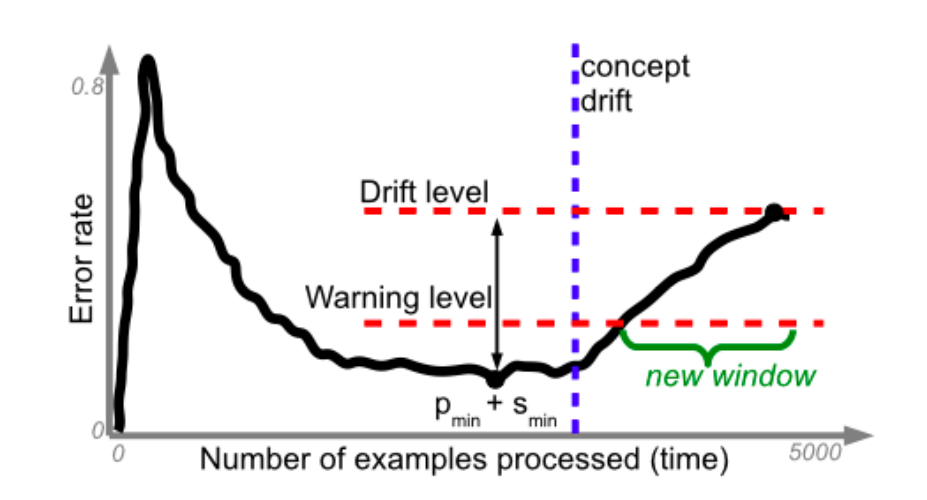

- At example $j$ the current decision model classifies the example 
- Compute the error and variance: $p_j$ and $s_j$
- If the error is
    - In-control: The current model is updated. Incorporate the example in the decision model
    - Warning: Maintain the current model. First Time: the lower limit of the window is: $L_{warning} = j$
    - Out-Control: Re-learn a new model using as training set the set of examples $[L_{warning} , j]$

## 2- SPC Module Implementation

The SPC module implements the detector class (SPCAlgorithm). Within this class, the following methods are defined:
- \_\_init__() : class initialization. It requires a function that initializes a river compatible estimator (ML model) to be given by the user.
- _update() : receives the ML model result, calculates the current error rate (p) and variance (s) and updates the Pmin and Smin if needed. Then it checks and returns the process status (In-control, Warning, Out-control).
- _model_train() : trains the ML model with the last iput or with a batch of inputs if re-training is needed.
- _reset_model() : re-initializes the ML model if re-training is needed, by calling the estimator initialization function given by the user..
- model_control() : wrapper function that calls reset_model() and train_model(), depending on the status returned by update(). This function is intended to be called by the user from outside the module.
- process_plot() : generates plots containing the process control results. This function is intended to be called by the user from outside the module.

In [1]:
import river
import matplotlib.pyplot as plt


status_dict = {
    "In-control"   : 0,
    "Warning Level": 1,
    "Out-control"  : 2
}

class SPCAlgorithm:
    def __init__(self, init_estimator):
        self.Pmin = 1.0
        self.Smin = 0.0
        self.num_negative = 0
        self.num_examples = 0
        self.error_rates = [] # for plotting
        self._init_estimator = init_estimator
        self._reset_model()
        self.warn = -1
        self.warning_level = []
        self.drift_level = []
        self.states = []

    def _update(self, y):
        # Update counts
        self.num_examples += 1
        if (y == False):
            self.num_negative += 1
        # Calculate p and s
        p = self.num_negative / self.num_examples
        s = (p * (1 - p) / self.num_examples) ** 0.5
        # Update Pmin and Smin
        if p + s != 0 and p + s < self.Pmin + self.Smin:
            self.Pmin = p
            self.Smin = s
        # Check process status
        self.warning_level.append(self.Pmin + 2 * self.Smin)        
        self.drift_level.append(self.Pmin + 3 * self.Smin)
        if p + s < self.Pmin + 2 * self.Smin:
            status = "In-control"
        elif p + s >= self.Pmin + 3 * self.Smin:
            status = "Out-control"
        else:
            status = "Warning Level"
        self.error_rates.append(p)
        return status        

    def _model_train(self, data):
        for i in range(data.shape[0]):
            try: # batch training
                x, y = data.iloc[i, :-1], data.iloc[i, -1]
            except: # single sample fitting
                x, y = data[:-1], data[-1]
        self.model.learn_one(x, y)
    
    def _reset_model(self):
        self.model = self._init_estimator()

    def model_control(self, data, sample_id):
        x = data.iloc[sample_id, :-1]
        y = data.iloc[sample_id, -1]
        y_pred = self.model.predict_one(x)

        status = self._update(y_pred==y)        
        # check detector status
        if status == 'Warning Level' and self.warn == -1 and sample_id!=0:
            self.warn = sample_id
        elif status == 'Out-control':
            self._reset_model()
            self._model_train(data.iloc[self.warn:sample_id+1,:]) # batch
        else:
            self._model_train(data.iloc[sample_id,:]) # single sample
        
        self.states.append(status_dict[status])
        return status, y, y_pred

    def process_plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        # Plot error and levels
        ax1.plot(range(1, len(self.error_rates) + 1), self.error_rates, marker='o', markersize=1, label='Error Rate')
        ax1.plot(range(1, len(self.warning_level) + 1), self.warning_level, color='r', linestyle='--', label='Warning Level')
        ax1.plot(range(1, len(self.drift_level) + 1), self.drift_level, color='g', linestyle='--', label='Drift Level')
        ax1.set_xlabel('Number of processed samples')
        ax1.set_ylabel('Error rate')
        ax1.set_title('Error Rate Across Processed Samples with SPC Indicators')
        ax1.grid(True)
        ax1.legend()
        # Plot states
        ax2.plot(range(1, len(self.states) + 1), self.states, marker='o', linestyle='-', color='b')
        ax2.set_xlabel('Number of processed samples')
        ax2.set_ylabel('State')
        ax2.set_title('State Across Processed Samples')
        ax2.set_yticks([0, 1, 2])
        ax2.set_yticklabels(['Normal', 'Warning', 'Out of Control'])
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

## 3 - Example Usage

### 3.1 - Data

TBD: ...brief presentation of our data...

In [4]:
! python SEAconcepts.py

C:\Users\anaca\OneDrive\Ambiente de Trabalho\DS2\DSM\dsm_SPC\SEAconcepts.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
import os
import pandas as pd

PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts.csv")

C:\Users\anaca\AppData\Local\Temp\ipykernel_14092\2554403509.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
data_stream = data_stream.iloc[0:30000, :]

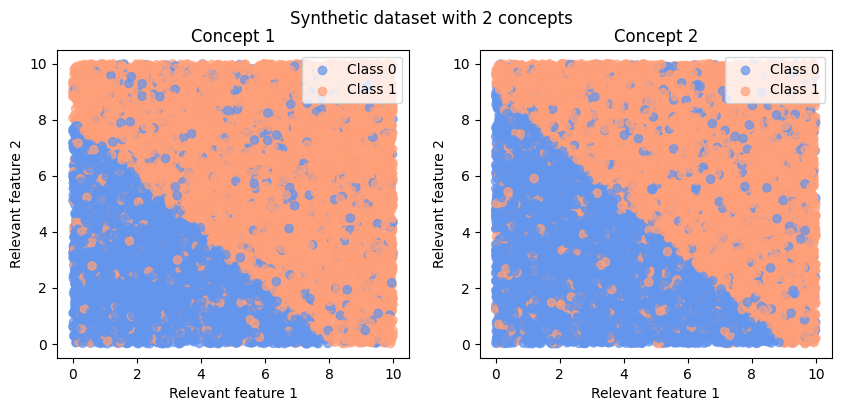

In [7]:
# Display the synthetic dataset
half_samples = data_stream.shape[0]//2
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
scatter_concept1 = ax1.scatter(data_stream.iloc[:half_samples, 0], data_stream.iloc[:half_samples, 1],
            c=data_stream['label'][:half_samples].map({0: 'cornflowerblue', 1: 'lightsalmon'}),
            label=data_stream['label'] , marker='o', alpha=0.7)

#ax1.legend(labels=['Class 0', 'Class 1'])
ax1.set_xlabel('Relevant feature 1')
ax1.set_ylabel('Relevant feature 2')
ax1.set_title('Concept 1')

scatter_concept2 = ax2.scatter(data_stream.iloc[half_samples:, 0], data_stream.iloc[half_samples:, 1],
            c=data_stream['label'][half_samples:].map({0: 'cornflowerblue', 1: 'lightsalmon'}),
            marker='o', alpha=0.7)

#ax2.legend(labels=['Class 0', 'Class 1'])
ax2.set_xlabel('Relevant feature 1')
ax2.set_ylabel('Relevant feature 2')
ax2.set_title('Concept 2')

ax1.legend(handles=[scatter_concept1, scatter_concept2], labels=['Class 0', 'Class 1'])
ax2.legend(handles=[scatter_concept1, scatter_concept2], labels=['Class 0', 'Class 1'])

leg = ax1.get_legend()
leg.legendHandles[0].set_color('cornflowerblue')
leg.legendHandles[1].set_color('lightsalmon')

leg = ax2.get_legend()
leg.legendHandles[0].set_color('cornflowerblue')
leg.legendHandles[1].set_color('lightsalmon')
plt.suptitle('Synthetic dataset with 2 concepts')
plt.show()

### 3.2 - User Manual

#### Setup:
- Download the SPC_module folder from https://github.com/miguelFigSilva/dsm_SPC
- Install the requirements (pip install -r SPC_module/requirements.txt)

Once the setup is completed, we can start using the module.

#### Initialization:
- Import the required packages (including the SPC module)

In [2]:
from SPC_module.SPC import SPCAlgorithm
from river import compat
from river import metrics
from river import preprocessing
from sklearn import linear_model
import pandas as pd
import os
import warnings
import numpy as np
import pyformulas as pf
import matplotlib.pyplot as plt
import time

warnings.filterwarnings("ignore")

- Create a function that initializes an estimator (machine learning model) of the user's choice. This estimator learning phase is the process we want to control using the SPC module.
    - Remark: The user shall ensure that the chosen estimator is compatible with the river package. 
    - Hint: there are available functions that help with this, e.g. river.compat.convert_sklearn_to_river().

In [3]:
def init_estimator_SGDClassifier():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
    estimator=linear_model.SGDClassifier(
        loss='log_loss',                   # 'log_loss' gives LOGISTIC REGRESSION. Uncomment to use it.
        #loss='hinge',                     # 'hinge' gives a LINEAR SVM. Uncomment to use it.
        #loss='perceptron',                # 'perceptron' is the linear loss used by the PERCEPTRON algorithm. Uncomment to use it.
        #loss='modified_huber',            # 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates. Uncomment to use it.
        #loss='squared_hinge',             # 'squared_hinge' is like hinge but is quadratically penalized. Uncomment to use it.
        eta0=0.001,
        learning_rate='constant',
        random_state=42
    ),
    classes=[False, True]
    )
    return model

- Get the data stream
- Initialize the SPC detector
- Initialize the metrics

In [6]:
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/synthetic_dataset.csv")

#### Running the Algorithm:

Once initialized, the SPC algorithm can run on the data stream. It will monitor the learning process of the chosen estimator and detect any anomalies or drifts.
The SPC algorithm provides real-time feedback on the status of the process. It 
categorizes the process into three states:
- Normal: The process is operating within expected parameters.
- Warning: Deviation detected, indicating a potential issue.
- Out of Control: Significant deviation detected, requiring intervention.

The user may use the algorithm’s output within the control loop.

- Implement the control loop
    - Run the algorithm
    - Monitor the detector outputs
    - Visualize results using the provided plotting functions

In [6]:
def live_error(error, ranges, size=100, screen=None, fig=None):
    if screen == None:
        screen = pf.screen(title='Error Evolution')
        fig = plt.figure()
        
    if len(error) > size:
        error = error[-size:] # plot the most recent error
        ranges = ranges[-size:]

    plt.clf()
    plt.title('Error evolution')
    plt.grid(True)
    plt.xlim(ranges[0], ranges[-1])
    plt.ylim(min(error)-0.01, max(error)+0.01)
    plt.plot(ranges, error, color='black', marker='.', linestyle='--')
    
    # Draw the figure
    fig.canvas.draw()

    # Convert the figure to an image
    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    screen.update(image)
    
    return screen, fig

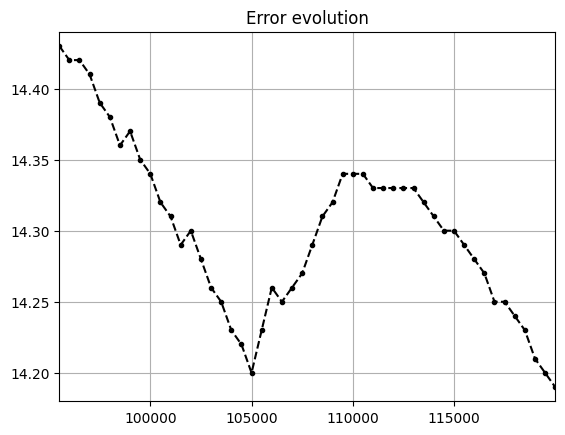

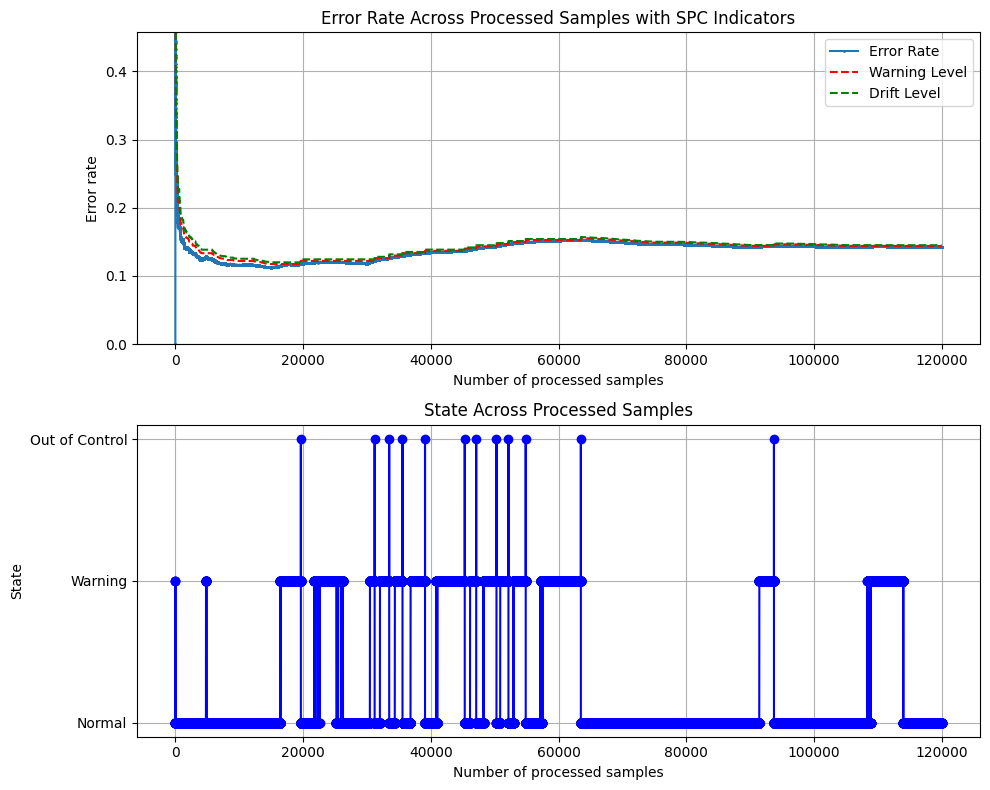

In [9]:
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts.csv")
spc_detector = SPCAlgorithm(init_estimator_SGDClassifier)
metric = metrics.Accuracy()

report = 500
warn = -1
retrain = -1
screen, fig, errors, ranges = None, None, [], []

for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)        
    metric.update(y, y_pred)

    if (i+1)%report == 0: 
        errors.append(100 - float(str(metric).split(' ')[-1][:-1]))
        ranges.append(i)
        screen, fig = live_error(errors, ranges, size=50, screen=screen, fig=fig)
        #print(f'{i+1} samples:', metric)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

#print(f'{i+1} samples:', metric)

# Plotting
time.sleep(5)
screen.close()
spc_detector.process_plot()

In [8]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 19654
Out-control at 31206
Out-control at 33488
Out-control at 35569
Out-control at 39096
Out-control at 45315
Out-control at 47111
Out-control at 50284
Out-control at 52160
Out-control at 54863
Out-control at 63498
Out-control at 93735


In [9]:
max(spc_detector.error_rates[1000:])

0.15437987857762359

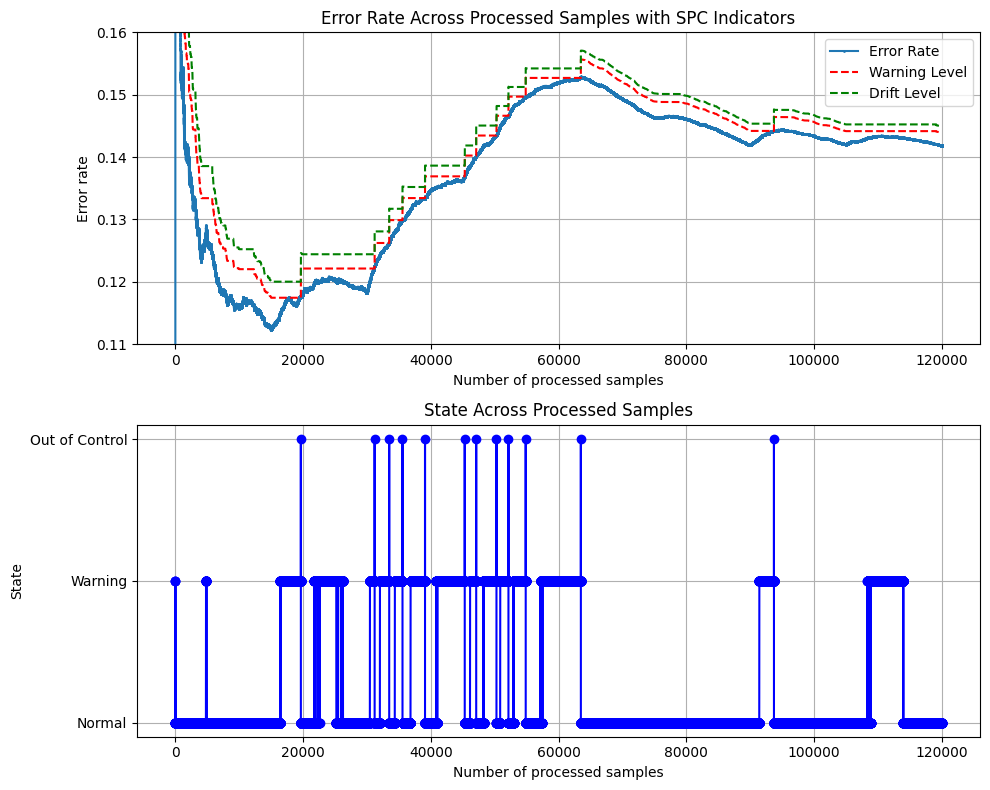

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot
ax1.plot(range(1, len(spc_detector.error_rates) + 1), spc_detector.error_rates, marker='o', markersize=1, label='Error Rate')
ax1.plot(range(1, len(spc_detector.warning_level) + 1), spc_detector.warning_level, color='r', linestyle='--', label='Warning Level')
ax1.plot(range(1, len(spc_detector.drift_level) + 1), spc_detector.drift_level, color='g', linestyle='--', label='Drift Level')
ax1.set_xlabel('Number of processed samples')
ax1.set_ylabel('Error rate')
ax1.set_title('Error Rate Across Processed Samples with SPC Indicators')
ax1.grid(True)
ax1.set_ylim(0.11, 0.16)
ax1.legend()
# Plotting states
ax2.plot(range(1, len(spc_detector.states) + 1), spc_detector.states, marker='o', linestyle='-', color='b')
ax2.set_xlabel('Number of processed samples')
ax2.set_ylabel('State')
ax2.set_title('State Across Processed Samples')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Normal', 'Warning', 'Out of Control'])
ax2.grid(True)
plt.tight_layout()
plt.show()

C:\Users\anaca\AppData\Local\Temp\ipykernel_15752\3738057616.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(errors), max(errors))  # Adjust ylim based on your error range
C:\Users\anaca\AppData\Local\Temp\ipykernel_15752\3738057616.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\anaca\AppData\Local\Temp\ipykernel_15752\3738057616.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


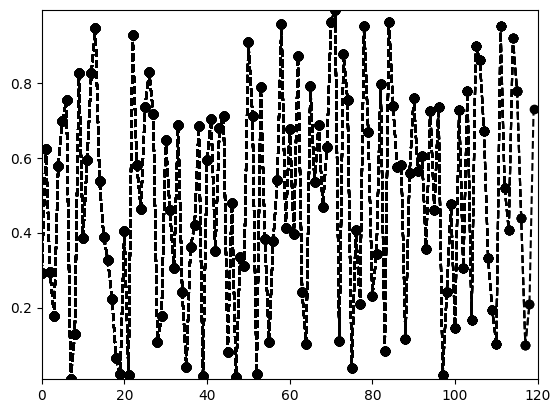

In [8]:
import pyformulas as pf
import matplotlib.pyplot as plt
import numpy as np
import time

fig = plt.figure()

screen = pf.screen(title='Error Evolution')

start_time = time.time()
errors = []

for i in range(120):
    t = time.time() - start_time

    # Generate error value (simulated for demonstration)
    error = np.random.rand()  # Simulated error, replace this with your actual error values
    errors.append(error)

    # Plot the growing list of errors
    plt.xlim(0, len(errors))
    plt.ylim(min(errors), max(errors))  # Adjust ylim based on your error range
    plt.plot(range(len(errors)), errors, c='black', marker='o', linestyle='--')

    # Draw the figure
    fig.canvas.draw()

    # Convert the figure to an image
    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Update the screen
    screen.update(image)

# Wait for a few seconds to keep the screen open
#time.sleep(5)
screen.close()

In [22]:
! pip install pyformulas

Using legacy 'setup.py install' for pyformulas, since package 'wheel' is not installed.
    Running setup.py install for pyformulas: started
    Running setup.py install for pyformulas: finished with status 'done'


You should consider upgrading via the 'c:\users\anaca\onedrive\ambiente de trabalho\ds2\dsm\dsm_env\scripts\python.exe -m pip install --upgrade pip' command.


C:\Users\anaca\AppData\Local\Temp\ipykernel_3700\1748414623.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(ranges[0], ranges[-1])
C:\Users\anaca\AppData\Local\Temp\ipykernel_3700\1748414623.py:23: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\anaca\AppData\Local\Temp\ipykernel_3700\1748414623.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


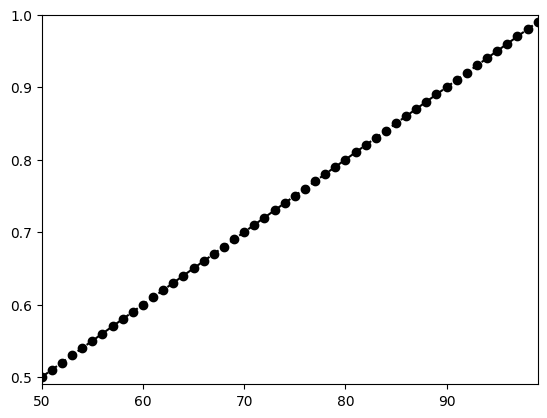

In [21]:
import time
e = []
r = []
screen, fig = None, None

for i in range(100):
    e.append(i*0.01)
    r.append(i)
    screen, fig = live_error(e, r, 50, screen, fig)

time.sleep(5)
screen.close()

1000 samples: Accuracy: 76.30%
2000 samples: Accuracy: 76.55%
3000 samples: Accuracy: 77.47%
4000 samples: Accuracy: 77.85%
5000 samples: Accuracy: 77.88%
6000 samples: Accuracy: 76.63%
7000 samples: Accuracy: 76.81%
8000 samples: Accuracy: 76.92%
9000 samples: Accuracy: 77.16%
10000 samples: Accuracy: 77.26%


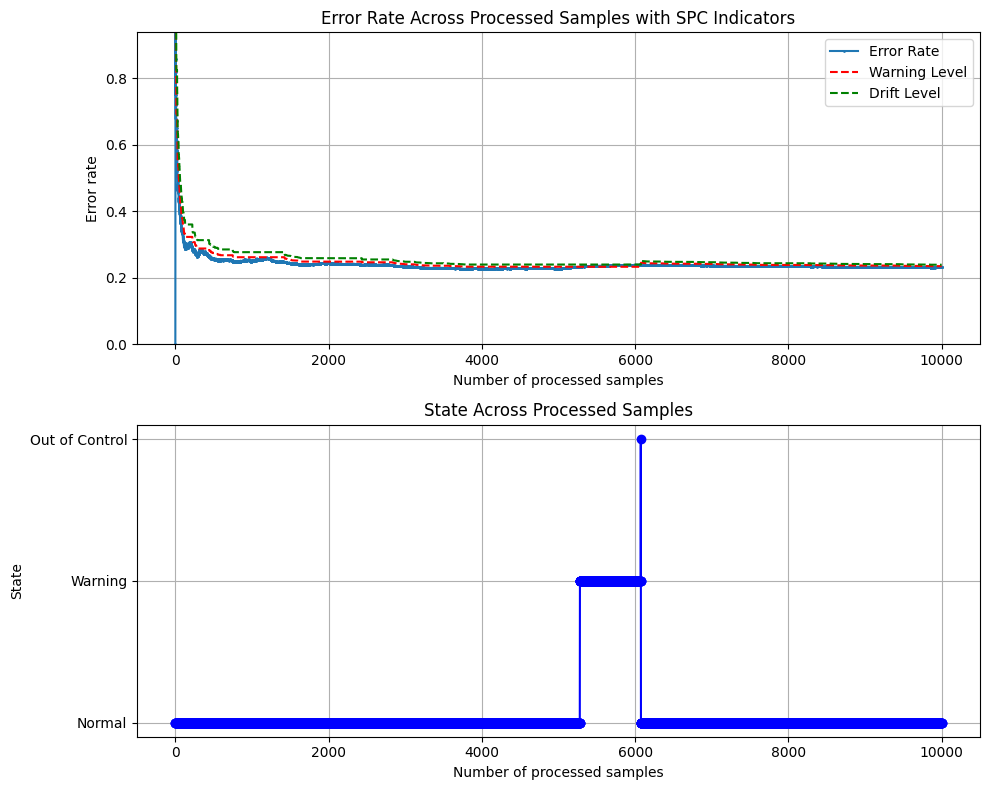

In [7]:
spc_detector = SPCAlgorithm(init_estimator_SGDClassifier)
metric = metrics.Accuracy()

report = 1000
warn = -1
retrain = -1
for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)        
    metric.update(y, y_pred)

    if (i+1)%report == 0: 
        print(f'{i+1} samples:', metric)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

#print(f'{i+1} samples:', metric)

# Plotting
spc_detector.process_plot()

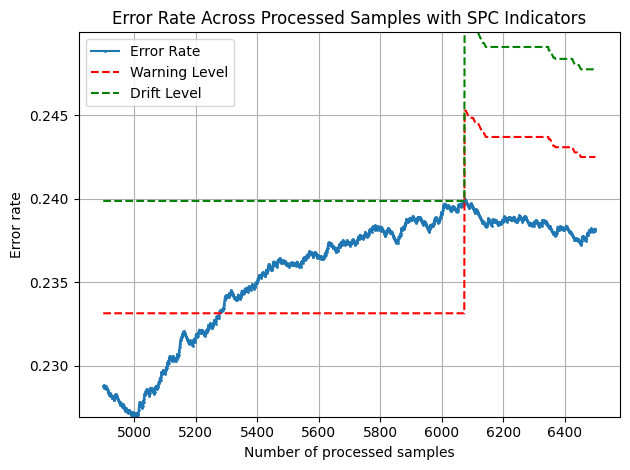

In [8]:
plt.plot(range(4900, 6500), spc_detector.error_rates[4900:6500], marker='o', markersize=1, label='Error Rate')
plt.plot(range(4900, 6500), spc_detector.warning_level[4900:6500], color='r', linestyle='--', label='Warning Level')
plt.plot(range(4900, 6500), spc_detector.drift_level[4900:6500], color='g', linestyle='--', label='Drift Level')
plt.xlabel('Number of processed samples')
plt.ylabel('Error rate')
plt.title('Error Rate Across Processed Samples with SPC Indicators')
plt.grid(True)
plt.ylim(min(spc_detector.error_rates[4900:6500]), max(spc_detector.error_rates[4900:6500]) + 0.01)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 6073


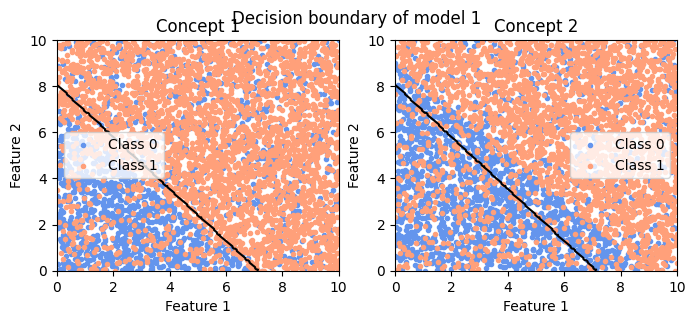

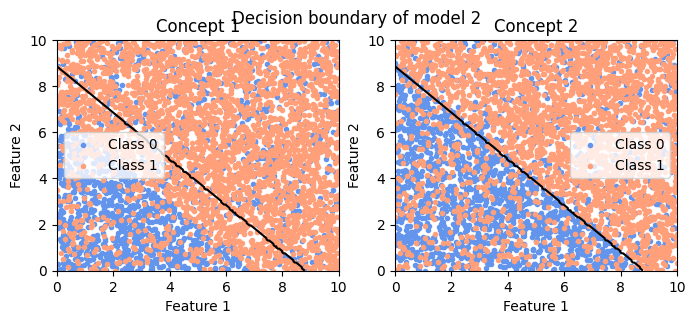

In [11]:
#drifts = sum([(spc_detector.error_rates[i] >= spc_detector.drift_level[i]) +0 for i in range(len(spc_detector.drift_level))])
spc_detector.models.append(spc_detector.model)
concept1 = data_stream.iloc[:5000, :]
concept2 = data_stream.iloc[5000:, :]

for i, model in enumerate(spc_detector.models):
    def decision_function(x):
        return np.array(model.predict_many(x) + 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    ax1.scatter(concept1[concept1['label'] == 0].iloc[:, 0],
                concept1[concept1['label'] == 0].iloc[:, 1],
                color='cornflowerblue', marker='.',
                label='Class 0')

    ax1.scatter(concept1[concept1['label'] == 1].iloc[:, 0],
                concept1[concept1['label'] == 1].iloc[:, 1],
                color='lightsalmon', marker='.', label='Class 1')

    ax2.scatter(concept2[concept2['label'] == 0].iloc[:, 0],
                concept2[concept2['label'] == 0].iloc[:, 1],
                color='cornflowerblue', marker='.', label='Class 0')

    ax2.scatter(concept2[concept2['label'] == 1].iloc[:, 0],
                concept2[concept2['label'] == 1].iloc[:, 1],
                color='lightsalmon', marker='.', label='Class 1')

    # Define a meshgrid using the first two features' ranges
    xx, yy = np.meshgrid(np.linspace(0, 10, 200), np.linspace(0, 10, 200))
    
    # Create a mesh grid for the third feature, assuming a constant value
    zz = np.random.uniform(0, 10, size=(xx.ravel().shape[0], 1))
    
    # Convert mesh grids into pandas DataFrames
    df_mesh = pd.DataFrame({'feature_0': xx.ravel(), 'feature_1': yy.ravel(), 'feature_2': zz.ravel()})

    # Use the decision function to predict class labels for each point on the mesh grid
    Z = decision_function(df_mesh).reshape(xx.shape)
    
    # Plot the decision boundary
    ax1.contour(xx, yy, Z, levels=[0], colors='black')
    ax2.contour(xx, yy, Z, levels=[0], colors='black')
    
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()
    ax1.set_title('Concept 1')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.legend()
    ax2.set_title('Concept 2')
    plt.suptitle(f"Decision boundary of model {i+1}")
    plt.show()
    plt.close()

## 4 - Findings and Conclusions

In [67]:
! python generate_data.py

Figure(1000x400)


C:\Users\anaca\OneDrive\Ambiente de Trabalho\DS2\DSM\dsm_SPC\generate_data.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\anaca\OneDrive\Ambiente de Trabalho\DS2\DSM\dsm_SPC\generate_data.py:81: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('cornflowerblue')
C:\Users\anaca\OneDrive\Ambiente de Trabalho\DS2\DSM\dsm_SPC\generate_data.py:82: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and wil

In [4]:
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts.csv")

In [9]:
from sklearn import naive_bayes

def init_estimator_GaussianNB():
    #model = preprocessing.StandardScaler()
    model = compat.convert_sklearn_to_river(
        estimator=naive_bayes.GaussianNB(),
        classes=[False, True]
    )
    return model

In [5]:
from sklearn import neural_network

def init_estimator_MLP():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
        estimator=neural_network.MLPClassifier(
            hidden_layer_sizes=(),
            activation='tanh',
            solver='adam',
            alpha=0.001,
            max_iter=1,
            random_state=42
        ),
        classes=[False, True]
    )
    return model

In [13]:
from river import tree

def init_estimator_EFDT():
    model = tree.ExtremelyFastDecisionTreeClassifier(
          grace_period=500, # Number of instances a leaf should observe between split attempts
          delta=0.05, # Significance level (1 - delta) to calculate the Hoeffding bound. Values closer to zero imply longer split decision delays
          nominal_attributes=['feature_0', 'feature_1', 'feature_2'],
          min_samples_reevaluate=500, # Number of instances a node should observe before reevaluating the best split
          max_depth=3
        )
    return model

In [14]:
from sklearn import ensemble

def init_estimator_RandomForestClassifier():
    model = compat.convert_sklearn_to_river(
        estimator=ensemble.RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )
    )
    return model

1000 samples: Accuracy: 66.70%
2000 samples: Accuracy: 70.65%
3000 samples: Accuracy: 74.83%
4000 samples: Accuracy: 77.92%
5000 samples: Accuracy: 79.72%
6000 samples: Accuracy: 81.18%
7000 samples: Accuracy: 82.66%
8000 samples: Accuracy: 83.49%
9000 samples: Accuracy: 84.03%
10000 samples: Accuracy: 84.56%
11000 samples: Accuracy: 84.77%
12000 samples: Accuracy: 85.11%
13000 samples: Accuracy: 85.46%
14000 samples: Accuracy: 85.90%
15000 samples: Accuracy: 86.17%
16000 samples: Accuracy: 86.23%
17000 samples: Accuracy: 86.25%
18000 samples: Accuracy: 86.38%
19000 samples: Accuracy: 86.67%
20000 samples: Accuracy: 86.72%
21000 samples: Accuracy: 86.95%
22000 samples: Accuracy: 87.03%
23000 samples: Accuracy: 87.10%
24000 samples: Accuracy: 87.20%
25000 samples: Accuracy: 87.28%
26000 samples: Accuracy: 87.30%
27000 samples: Accuracy: 87.38%
28000 samples: Accuracy: 87.45%
29000 samples: Accuracy: 87.43%
30000 samples: Accuracy: 87.52%
31000 samples: Accuracy: 87.23%
32000 samples: Ac

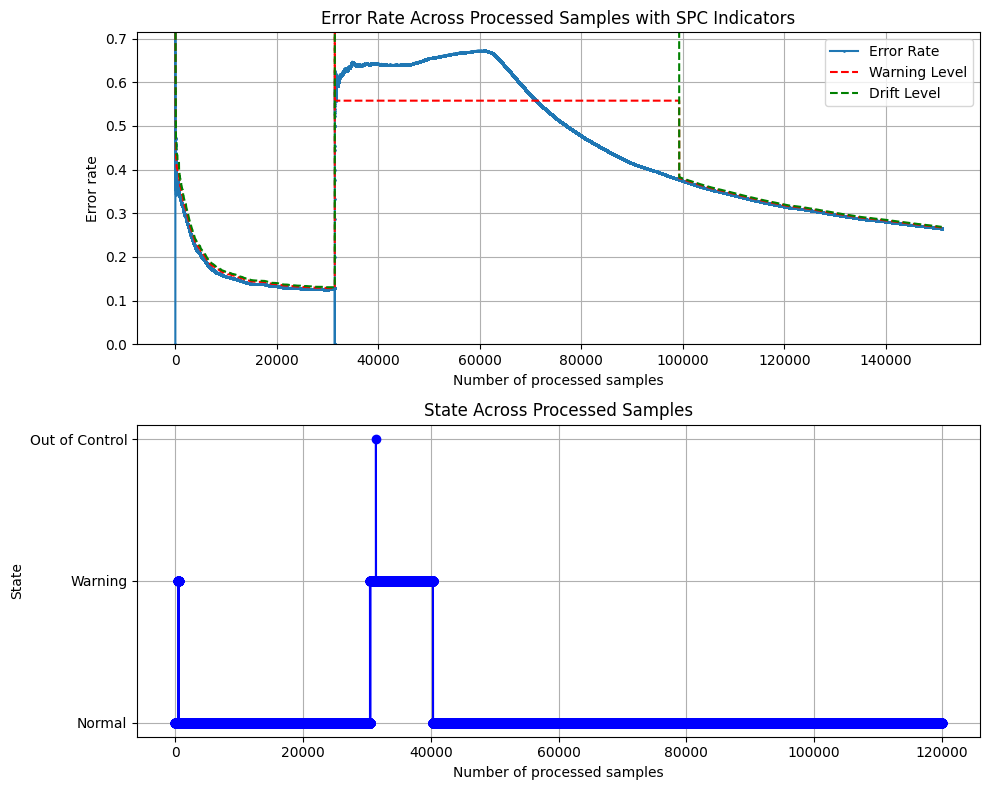

In [6]:
spc_detector = SPCAlgorithm(init_estimator_MLP)
metric = metrics.Accuracy()

report = 1000
warn = -1
retrain = -1
for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)        
    metric.update(y, y_pred)

    if (i+1)%report == 0: 
        print(f'{i+1} samples:', metric)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

#print(f'{i+1} samples:', metric)

# Plotting
spc_detector.process_plot() # 128, 64, 32 com lr 0.05 e 1000 max_iter

In [7]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 31408


1000 samples: Accuracy: 85.10%
2000 samples: Accuracy: 86.25%
3000 samples: Accuracy: 86.60%
4000 samples: Accuracy: 87.35%
5000 samples: Accuracy: 87.16%
6000 samples: Accuracy: 87.20%
7000 samples: Accuracy: 87.54%
8000 samples: Accuracy: 87.61%
9000 samples: Accuracy: 87.56%
10000 samples: Accuracy: 87.59%
11000 samples: Accuracy: 87.39%
12000 samples: Accuracy: 87.45%
13000 samples: Accuracy: 87.52%
14000 samples: Accuracy: 87.74%
15000 samples: Accuracy: 87.83%
16000 samples: Accuracy: 87.52%
Num examples post retraining =  673
Num negatives post retraining =  96
17000 samples: Accuracy: 87.33%
18000 samples: Accuracy: 87.41%
19000 samples: Accuracy: 87.51%
20000 samples: Accuracy: 87.41%
21000 samples: Accuracy: 87.51%
22000 samples: Accuracy: 87.49%
23000 samples: Accuracy: 87.47%
24000 samples: Accuracy: 87.51%
25000 samples: Accuracy: 87.50%
26000 samples: Accuracy: 87.48%
27000 samples: Accuracy: 87.50%
28000 samples: Accuracy: 87.51%
29000 samples: Accuracy: 87.48%
30000 sam

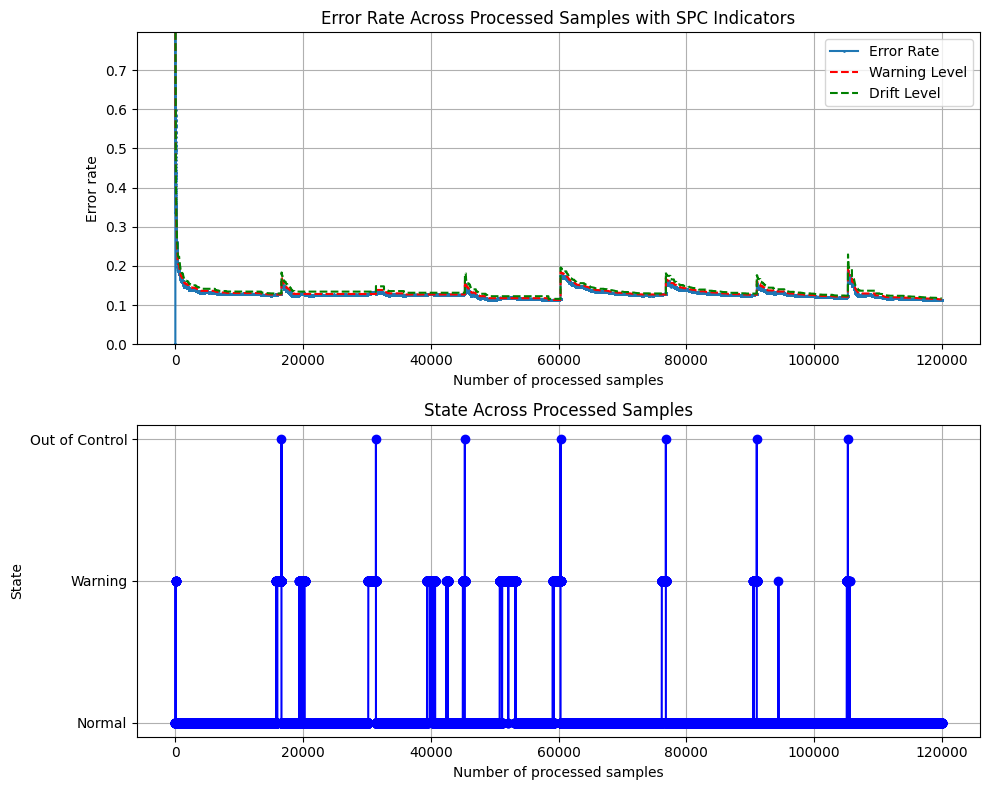

In [10]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
metric = metrics.Accuracy()

report = 1000
warn = -1
retrain = -1
for i in range(data_stream.shape[0]):
    status, y, y_pred = spc_detector.model_control(data_stream, i)        
    metric.update(y, y_pred)

    if (i+1)%report == 0: 
        print(f'{i+1} samples:', metric)

    if status == 'Warning Level' and warn == -1 and i!=0:
        warn = i
        retrain = -1
        #print(f'Warning after {i+1} samples')
    elif status == 'Out-control' and retrain == -1 and i!=0:
        #print(f'Re-train model after {i+1} samples')
        retrain = i
        warn = -1
    else:
        warn = -1
        retrain = -1

#print(f'{i+1} samples:', metric)

# Plotting
spc_detector.process_plot()

In [7]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 30673
Out-control at 30674
Out-control at 30675
Out-control at 46279
Out-control at 46280
Out-control at 46281
Out-control at 46282
Out-control at 60633
Out-control at 60652
Out-control at 60653
Out-control at 60654
Out-control at 60655
Out-control at 91423
Out-control at 91424
Out-control at 106086
Out-control at 106117


In [11]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 16617
Out-control at 31412
Out-control at 45334
Out-control at 60319
Out-control at 76811
Out-control at 91046
Out-control at 105313


In [26]:
for i, state in enumerate(spc_detector.states):
    if state == 2:
        print(f'Out-control at {i}')

Out-control at 16609
Out-control at 30885
Out-control at 32463
Out-control at 45397
Out-control at 45710
Out-control at 61118
Out-control at 62024
Out-control at 76336
Out-control at 91245
Out-control at 105314


(0.1, 0.2)

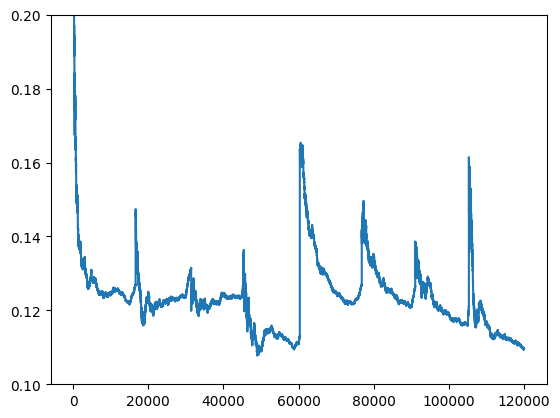

In [12]:
plt.plot(spc_detector.ps[2:])
plt.ylim(0.1, 0.2)

In [10]:
spc_detector.ps[45751]

1.0

TBD: ...present our analysis to the performance with different ML models, etc...

1) SEA concepts dataset

2) Exponentially decaying factor SPC

3) Slidding windows SPC

4) Non-linear concepts, more complex linear concepts (try SVM)

5) Change in hidden variables concepts